In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp

In [38]:
#1 norm inducing sparcity around q_hp and no limit on q_hp
def solve_inner(C, q_hp, delta_T_i, delta_T_a, q_solar, SPC_sum, DHW_sum,
                Q_DHW_estimate, q_max, delta_t):
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - Q_DHW_estimate - SPC_sum + DHW_sum

    # CVXPY variables
    a = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    #w_w = cp.Variable(nonneg=True)
    w = cp.Variable()
    e = cp.Variable()
    z = cp.Variable(N, nonneg=True)
    u = cp.Variable(N)
    q_hat = cp.Variable(N)

    # Expression
    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar + w * np.ones(N) *
            delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_max,
        a >= 1 / 25
    ]

    # Objective weights
    ph_q = 100
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 200
    objective = cp.Minimize(
        ph_q * cp.norm1(q_hat-q_hp) * delta_t + 
        phi_e * e ** 2 * delta_t +
        phi_u * cp.norm2(u) * delta_t +
        phi_z * cp.maximum(0, -(q_hat + z)).sum() * delta_t
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=False)

    # Extract values
    R_a = 1 / a.value
    ws_val = w_s.value
    #ww_val = w_w.value
    w_val = w.value
    q_hat_val = q_hat.value

    # RMSE for dTi (u)
    rmse_dTi = np.sqrt(np.mean(u.value ** 2))

    # RMSE for q_hat vs q_hp
    rmse_q = np.sqrt(np.mean((q_hat.value - q_hp * delta_t) ** 2))

    return R_a, ws_val, w_val, rmse_q, rmse_dTi, q_hat_val, Q_sc

In [39]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
0,EOH0279,2020-10-26 00:00:00,00:00:00,NaN,0.000,0.000,0.008,9.38,23.14,23.35,...,EH22,00:00:00,8.90,6.10,79.75,5.6,0.154,0.0,0.0,19.30
1,EOH1703,2020-10-26 00:00:00,00:00:00,NaN,0.013,0.242,0.078,7.08,25.04,24.04,...,NE15,00:00:00,7.00,4.30,81.71,4.1,0.170,0.0,0.0,14.30
2,EOH1703,2020-10-26 00:30:00,00:30:00,NaN,0.029,0.622,0.212,6.83,25.43,24.23,...,NE15,00:30:00,6.95,4.05,81.93,4.1,0.085,0.0,0.0,15.85
3,EOH0279,2020-10-26 00:30:00,00:30:00,NaN,0.000,0.000,0.019,9.33,22.54,22.80,...,EH22,00:30:00,8.85,6.30,79.94,5.6,0.077,0.0,0.0,17.00
4,EOH0279,2020-10-26 01:00:00,01:00:00,NaN,0.000,2.730,0.967,9.21,35.27,30.93,...,EH22,01:00:00,8.80,6.50,80.13,5.6,0.000,0.0,0.0,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505054,EOH3154,2023-09-29 00:00:00,00:00:00,NaN,0.000,44801.768,14989.282,12.44,18.87,50.46,...,EH15,00:00:00,12.80,12.80,90.62,11.3,0.333,0.0,0.0,16.00
505055,EOH1637,2023-09-29 00:00:00,00:00:00,NaN,203.311,43996.381,13830.005,12.17,16.70,16.53,...,PH7,00:00:00,13.20,13.20,86.43,11.0,0.004,0.0,0.0,17.00
505056,EOH2329,2023-09-29 00:00:00,00:00:00,NaN,31.139,14128.100,5775.602,12.44,24.80,26.31,...,EH4,00:00:00,12.90,12.90,90.75,11.4,0.378,0.0,0.0,15.00
505057,EOH2675,2023-09-29 00:00:00,00:00:00,NaN,212.928,59675.471,19247.887,12.44,14.82,14.85,...,EH9,00:00:00,13.00,13.00,93.04,11.9,0.024,0.0,0.0,24.30


In [40]:
unique_ids = df_train_detached["Property_ID"].unique()

df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual","HP_Size_kW",
    "HP_Installed", "House_SAP"
]

df_house_train = {}
for id_use in unique_ids:
    df_house_train[id_use] = df_house[df_house["Property_ID"] == id_use]

In [41]:
missing_counts = df_house[df_house["Property_ID"].isin(unique_ids)][["Floor_Height", "Total_Floor_Area"]].isna().sum()
print(missing_counts)


Floor_Height        0
Total_Floor_Area    0
dtype: int64


In [42]:
trained_params = pd.DataFrame(index=["Floor Area", "No_Storeys", "Wall_Type",
                                     "HP_Type", "House_SAP",
                                     "C", "R_a", "w_s", "w_w", "w",
                                     "Q_hat", "Q_sc", "rmse_dTi",
                                     "rmse_q_hp"])

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
df_single = df_single.set_index('Timestamp')

#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_index = df_single[df_single.index >= t_start]
df_index = df_index[df_index.index <= t_end]
df_index = df_index[
    (df_index.index <= t_mid_end) | (df_index.index >= t_mid_start)]

# Create time index for q_hat arrays
time_index = df_index.index[:-1]
df_q_id = pd.DataFrame(index=time_index)

for id_use in unique_ids:
    wall = df_house_train[id_use].Wall_Type.to_string()
    storeys = df_house_train[id_use].No_Storeys.to_string()
    floor_area = df_house_train[id_use].Total_Floor_Area.to_string()
    hp_type = df_house_train[id_use].HP_Installed.to_string()
    house_sap = df_house_train[id_use].House_SAP.to_string()

    df_single = df_train_detached[
        df_train_detached["Property_ID"] == id_use].copy()

    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single[
        "Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single[
        "Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] -
         df_single["Internal_Air_Temperature"])

    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())

    df_single = df_single_cleaned

    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())

    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()

    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(
        method='time', limit=4, limit_direction='both')

    df_single_interpolated = df_single.copy()
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")

    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    #df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]

    # Time range
    t_start = pd.to_datetime("2022-6-01 00:00:00")
    t_end = pd.to_datetime("2022-08-30 23:59:00")
    df_DHW = df_heating_single[
        (df_heating_single.index >= t_start) & (
                    df_heating_single.index <= t_end)
        ].copy()

    df_DHW.drop("Property_ID", axis=1, inplace=True)
    df_DHW.drop("half-hour", axis=1, inplace=True)
    df_DHW.drop("Date", axis=1, inplace=True)
    df_DHW.drop("has_data", axis=1, inplace=True)

    i = 24

    df_numeric = df_DHW.select_dtypes(include='number')

    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()

    df_DHW_only = df_resampled[
        df_resampled["Heat_Pump_Energy_Output_Diff"] <= 0.15]

    DHW_sum = []
    DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

    df_spc_only = df_resampled[
        df_resampled["Heat_Pump_Energy_Output_Diff"] > 0.15]
    SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum() * 24

    # ------ Prepare Training Data ----------
    df_heating_single = df_single_processed.copy()

    #time range
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
    t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
    t_end = pd.to_datetime("2022 12 31 23:59:59")
    df_heating_annual = df_heating_single[df_heating_single.index >= t_start]
    df_heating_annual = df_heating_annual[df_heating_annual.index <= t_end]
    df_heating_annual = df_heating_annual[
        (df_heating_annual.index <= t_mid_end) | (df_heating_annual
                                                  .index >= t_mid_start)]

    t_step = 30  # minutes
    delta_t = t_step / 60

    T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy())
    T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy())
    delta_T_a = (
        df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy())
    delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t)
    q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy())
    q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy())
    v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy())

    N = len(delta_T_i)

    Q_DHW_estimate = df_house_train[id_use].MCS_DHWAnnual.to_numpy()
    q_max = df_house_train[id_use].HP_Size_kW.to_numpy()

    # Create time index for in the loop q_hat arrays
    time_index = df_heating_annual.index[:-1]
    df_q_results = pd.DataFrame(index=time_index)

    # Grid search and store results
    C_values = np.arange(1.5, 6, 0.1)
    results = []

    for C in C_values:
        R_a, ws, w, rmse_q, rmse_dTi, q_hat_val, Q_sc = solve_inner(C, q_hp,
                                                                    delta_T_i,
                                                                    delta_T_a,
                                                                    q_solar,
                                                                    SPC_sum,
                                                                    DHW_sum,
                                                                    Q_DHW_estimate,
                                                                    q_max,
                                                                    delta_t)
        
        #Save each q_hat under C value for iteration
        df_q_results[f"C_{C:.1f}"] = q_hat_val

        results.append({
            "C": C,
            "R_a": R_a,
            "w_s": ws,
            #"w_w": ww, #wind doesn't do much on average
            "w": w,
            "Q_hat": np.sum(q_hat_val),
            "Q_sc": Q_sc,
            "rmse_q": rmse_q,
            "rmse_dTi": rmse_dTi
        })
        #print(f"C={C:.2f} | R_a={R_a:.4f} | w_s={ws:.4f} | w={w:.4f} | "
        #      f"rmse_q={rmse_q:.4f} | rmse_dTi={rmse_dTi:.4f}")

    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    df_results.sort_values(by="rmse_dTi", ascending=True, inplace=True)

    top_result = df_results.iloc[0]
    print(top_result)

    df_q_id[id_use] = df_q_results[f"C_{top_result["C"]:.1f}"]

    '''
    print("Optimal C_a:", top_result["C"])
    print("Optimal R_a:", top_result["R_a"])
    print("w_s (solar gain):", top_result["w_s"])
    print("w_w (wind effect):", 'NA')
    print("w (bias):", top_result["w"])
    print("Q_hat total:", top_result["Q_hat"])
    print("Q_sc:", top_result["Q_sc"])
    print("RMSE dTi:", top_result["rmse_dTi"])
    print("RMSE q_hat:", top_result["rmse_q"])
    '''
    trained_params[id_use] = [floor_area, storeys, wall, hp_type, house_sap, 
                              top_result["C"], top_result["R_a"], 
                              top_result["w_s"], "NA",
                              top_result["w"], top_result["Q_hat"],
                              top_result["Q_sc"], top_result["rmse_dTi"],
                              top_result["rmse_q"]]
    
    
    

C                           2.5
R_a                    7.834831
w_s                    0.000403
w           0.13062135950863765
Q_hat               6020.849719
Q_sc        [5521.046999999999]
rmse_q                 0.384977
rmse_dTi               0.129272
Name: 10, dtype: object


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C                            1.5
R_a                        7.952
w_s                     0.000691
w            0.38549484387469396
Q_hat                7285.304726
Q_sc        [6787.9180000000015]
rmse_q                  0.402039
rmse_dTi                0.227948
Name: 0, dtype: object


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C                          3.1
R_a                   5.304426
w_s                   0.000818
w           0.8308058744044822
Q_hat              9327.820292
Q_sc        [8829.04949999999]
rmse_q                0.627877
rmse_dTi               0.16068
Name: 16, dtype: object
C                           2.3
R_a                    8.292187
w_s                    0.001245
w           0.24315193072554875
Q_hat               4278.012837
Q_sc        [3780.213000000007]
rmse_q                 0.345314
rmse_dTi               0.153283
Name: 8, dtype: object


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C                            4.2
R_a                    22.126495
w_s                     0.000071
w            0.38438820064396906
Q_hat                   0.002767
Q_sc        [-535.3095000000012]
rmse_q                  0.362683
rmse_dTi                0.383782
Name: 27, dtype: object
C                            5.7
R_a                      3.34699
w_s                     0.001192
w             0.6522038280805403
Q_hat               14617.588066
Q_sc        [14119.062999999998]
rmse_q                  0.943427
rmse_dTi                0.159984
Name: 42, dtype: object
C                           3.8
R_a                    4.074255
w_s                    0.000408
w            0.7442140815231081
Q_hat              10252.922987
Q_sc        [9753.815508474578]
rmse_q                 0.635832
rmse_dTi               0.125301
Name: 23, dtype: object
C                           1.8
R_a                   10.016712
w_s                     0.00112
w           0.15853420489196038
Q_hat           

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C                           3.5
R_a                    7.330371
w_s                    0.000845
w           0.13745230241950993
Q_hat              10198.053734
Q_sc        [9699.044098013243]
rmse_q                 0.600654
rmse_dTi               0.264015
Name: 20, dtype: object
C                           2.4
R_a                    8.059194
w_s                     0.00056
w           0.16956228140708815
Q_hat               7073.488066
Q_sc        [6574.480500000001]
rmse_q                 0.454198
rmse_dTi               0.126418
Name: 9, dtype: object


In [43]:
trained_params.to_csv("trained_params_1norm_v4.csv", index=False)
trained_params


,EOH0279,EOH1703,EOH1485,EOH0546,EOH2329,EOH2675,EOH3154,EOH0413,EOH1637,EOH3196
Floor Area,2066 172.33,2381 91.0,1569 130.12,1692 107.51,585 109.54,1156 135.55,1149 119.44,318 106.36,736 111.84,76 107.27
No_Storeys,2066 2.0,2381 2.0,1569 2.0,1692 1.0,585 1.0,1156 2.0,1149 1.0,318 2.0,736 2.0,76 2.0
Wall_Type,2066 Cavity_Insulated,2381 Cavity_Insulated,1569 Cavity_Insulated,1692 Cavity_Insulated,585 Cavity_Insulated,1156 Cavity_Insulated,1149 Cavity_Insulated,318 Cavity_Insulated,736 Cavity_Insulated,76 Cavity_No_insulation
HP_Type,2066 ASHP,2381 ASHP,1569 HT_ASHP,1692 ASHP,585 ASHP,1156 HT_ASHP,1149 HT_ASHP,318 Hybrid,736 HT_ASHP,76 ASHP
House_SAP,2066 A,2381 NaN,1569 C,1692 C,585 C,1156 E,1149 D,318 D,736 C,76 D
C,2.5,1.5,3.1,2.3,4.2,5.7,3.8,1.8,3.5,2.4
R_a,7.834831,7.952,5.304426,8.292187,22.126495,3.34699,4.074255,10.016712,7.330371,8.059194
w_s,0.000403,0.000691,0.000818,0.001245,0.000071,0.001192,0.000408,0.00112,0.000845,0.00056
w_w,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
w,0.13062135950863765,0.38549484387469396,0.8308058744044822,0.24315193072554875,0.38438820064396906,0.6522038280805403,0.7442140815231081,0.15853420489196038,0.13745230241950993,0.16956228140708815


In [44]:
for id_use in df_house_train:
    print(df_house_train[id_use].House_SAP)
    print(df_house_train[id_use].HP_Installed)

2066    A
Name: House_SAP, dtype: object
2066    ASHP
Name: HP_Installed, dtype: object
2381    NaN
Name: House_SAP, dtype: object
2381    ASHP
Name: HP_Installed, dtype: object
1569    C
Name: House_SAP, dtype: object
1569    HT_ASHP
Name: HP_Installed, dtype: object
1692    C
Name: House_SAP, dtype: object
1692    ASHP
Name: HP_Installed, dtype: object
585    C
Name: House_SAP, dtype: object
585    ASHP
Name: HP_Installed, dtype: object
1156    E
Name: House_SAP, dtype: object
1156    HT_ASHP
Name: HP_Installed, dtype: object
1149    D
Name: House_SAP, dtype: object
1149    HT_ASHP
Name: HP_Installed, dtype: object
318    D
Name: House_SAP, dtype: object
318    Hybrid
Name: HP_Installed, dtype: object
736    C
Name: House_SAP, dtype: object
736    HT_ASHP
Name: HP_Installed, dtype: object
76    D
Name: House_SAP, dtype: object
76    ASHP
Name: HP_Installed, dtype: object


RMSE of q_hp: 0.7193331340608806


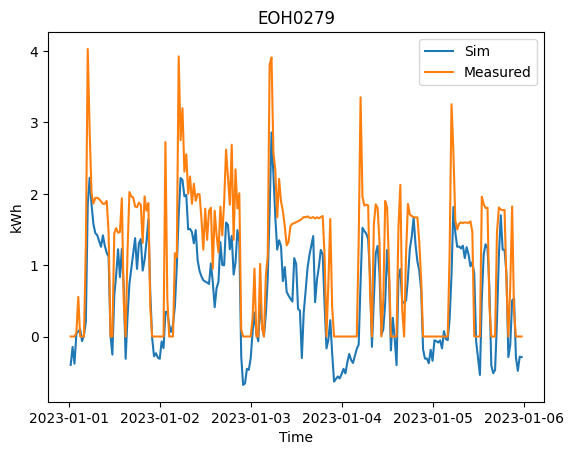

RMSE of q_hp: 0.6706432127935406


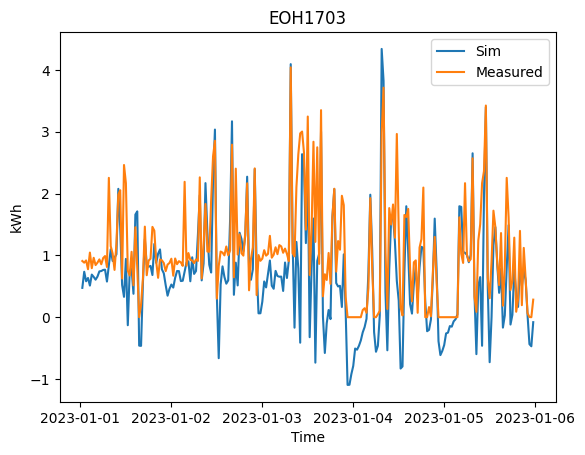

RMSE of q_hp: 1.2617817354178047


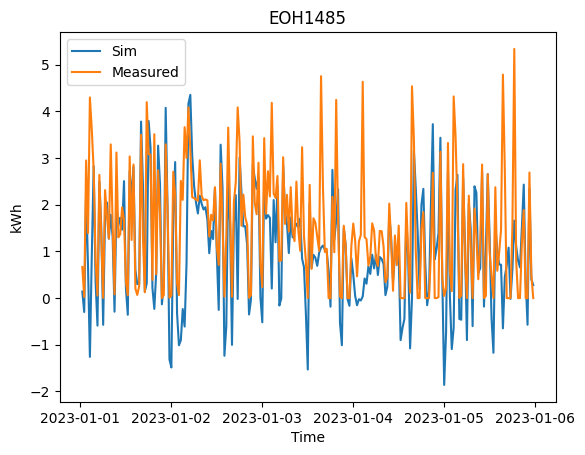

RMSE of q_hp: 0.8479139912851569


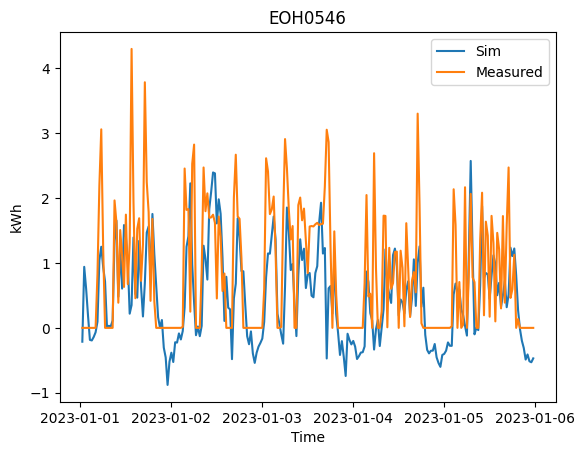

RMSE of q_hp: 1.8194072617666168


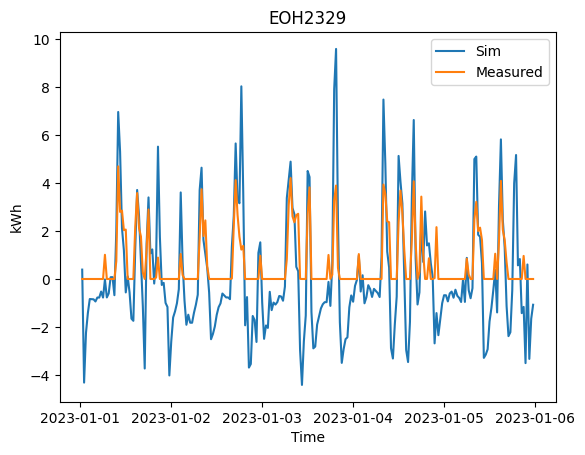

RMSE of q_hp: 1.3145474014098684


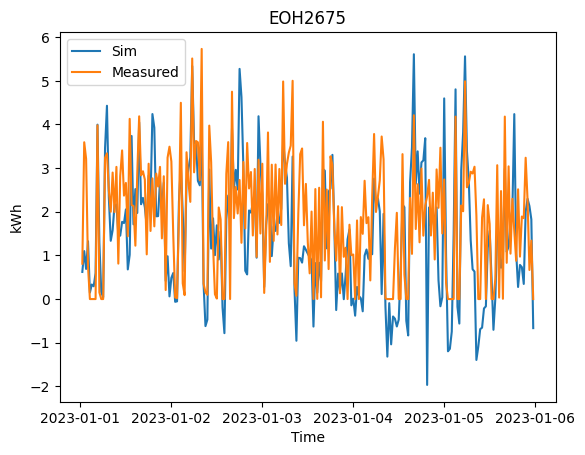

RMSE of q_hp: 0.9864545106810024


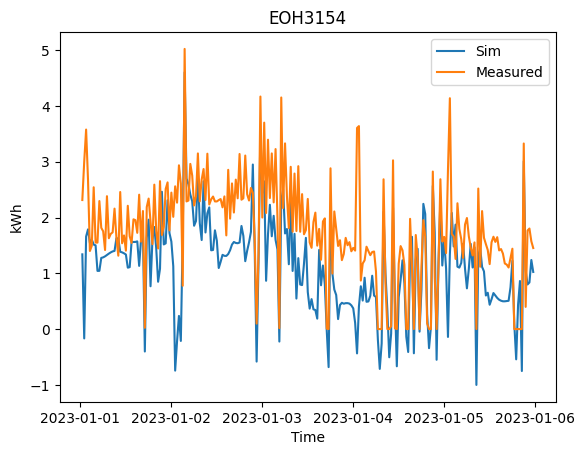

RMSE of q_hp: 0.9934224011447651


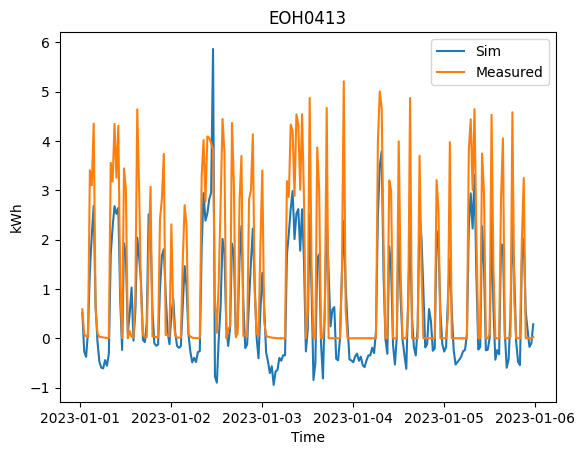

RMSE of q_hp: 1.73859198062379


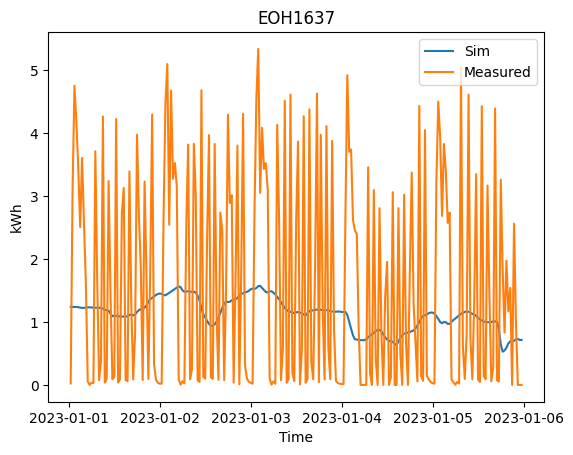

RMSE of q_hp: 0.9553064801638045


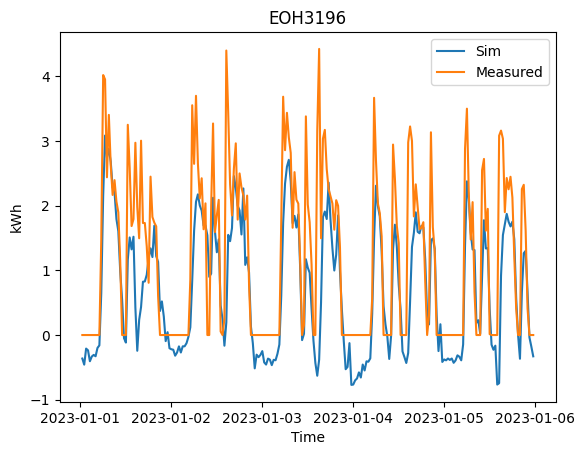

In [45]:
# ------- Look at heat supply performance in validation data ------

for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    t_start = pd.to_datetime("2023 01 01 00:00:00")
    t_end = pd.to_datetime("2023 01 05 23:59:00")
    df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    
    q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  - w_s *  
            q_solar_val  - w * np.ones(len(T_a_val), )* delta_t )
    
    e_q = q_hat_sim - q_hp_val
    rmse_q_val = np.sqrt(np.mean(e_q**2))
    print(f"RMSE of q_hp: {rmse_q_val}")
    
    plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("kWh")
    plt.title(f"{id_use}")
    plt.show()

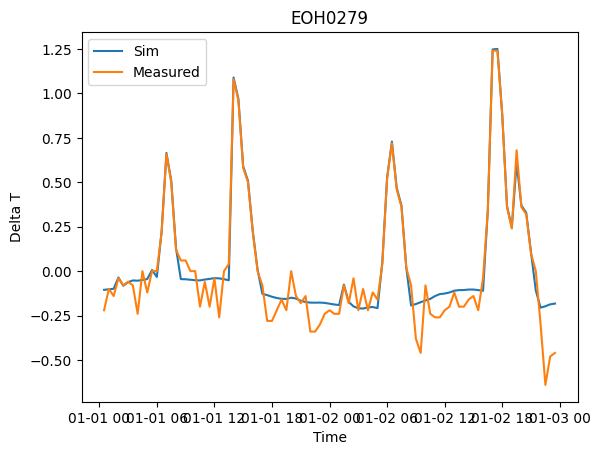

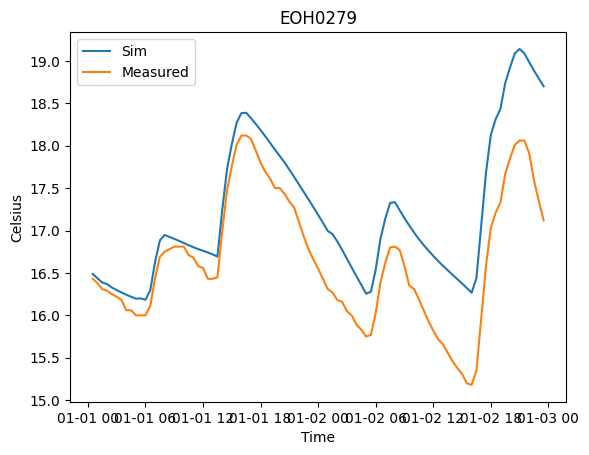

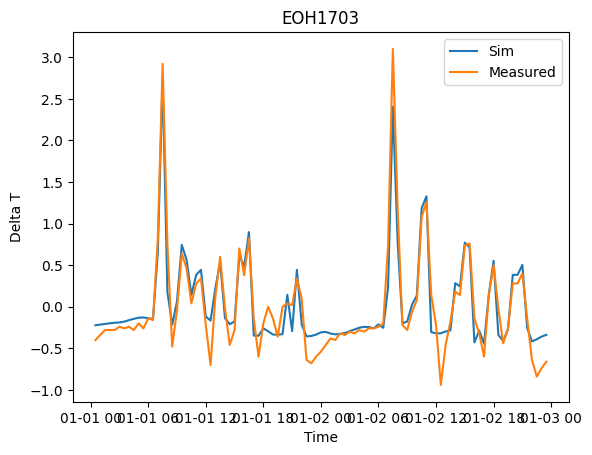

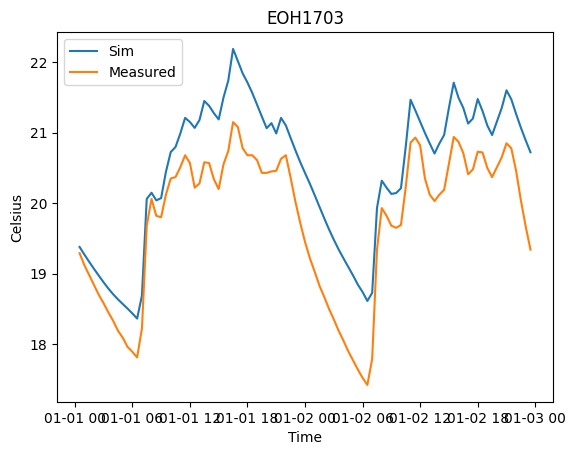

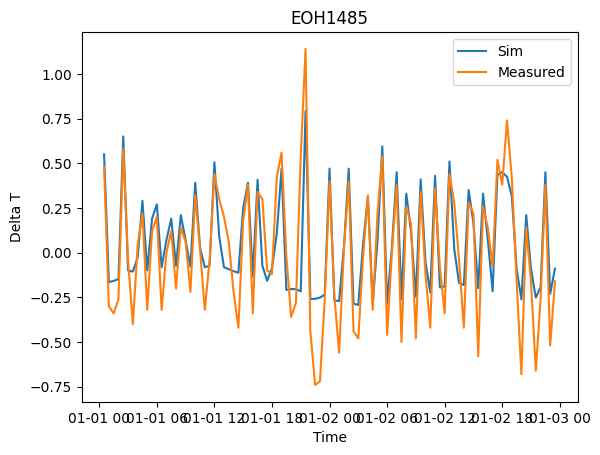

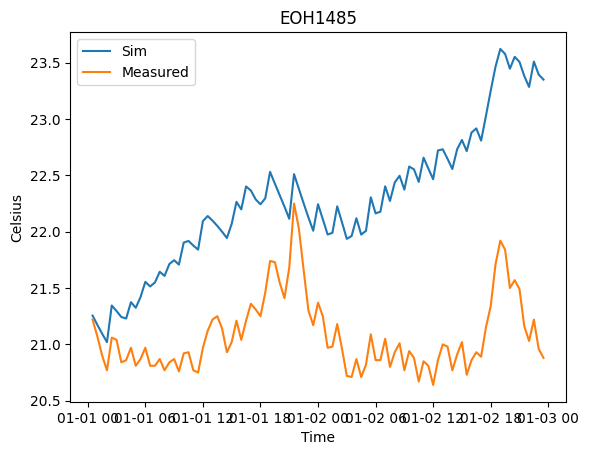

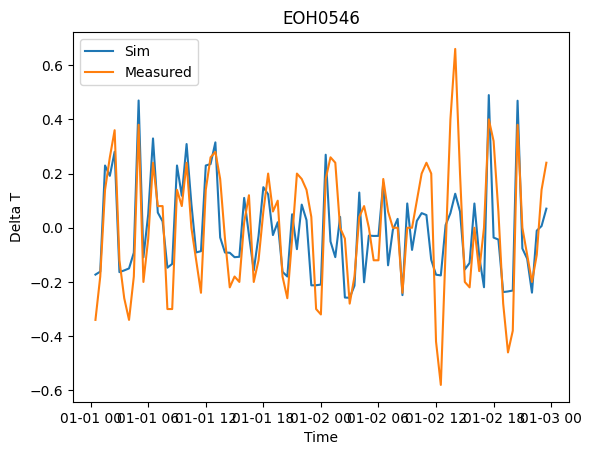

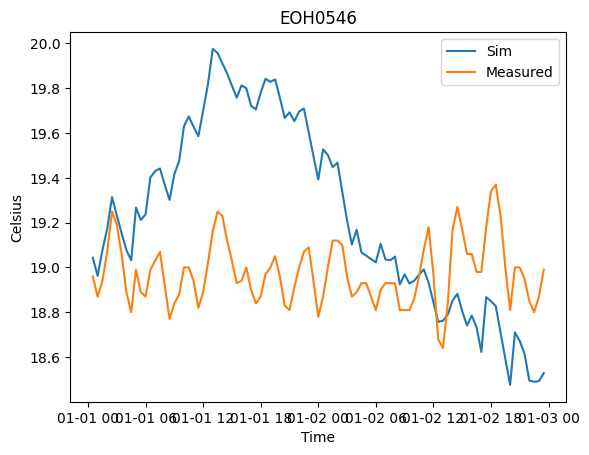

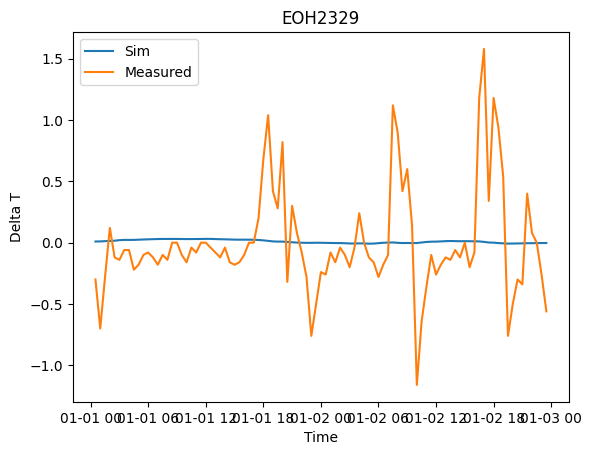

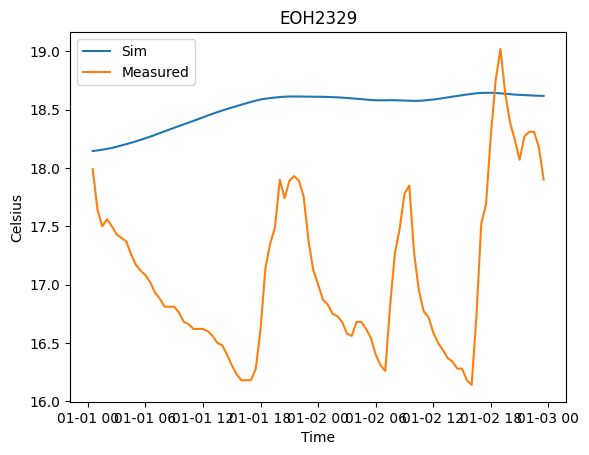

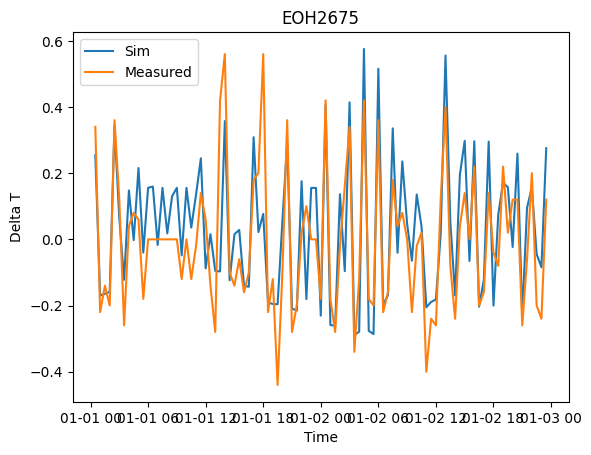

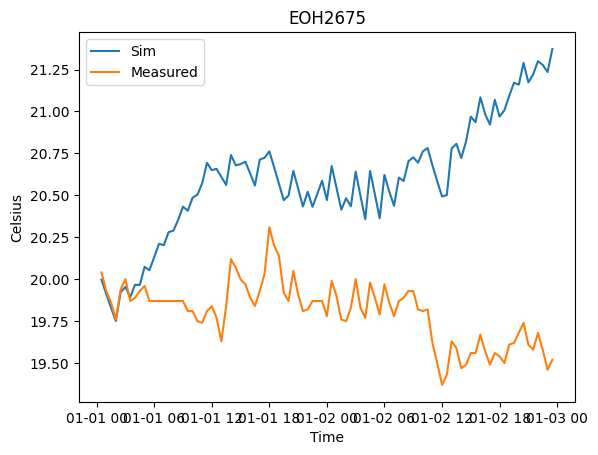

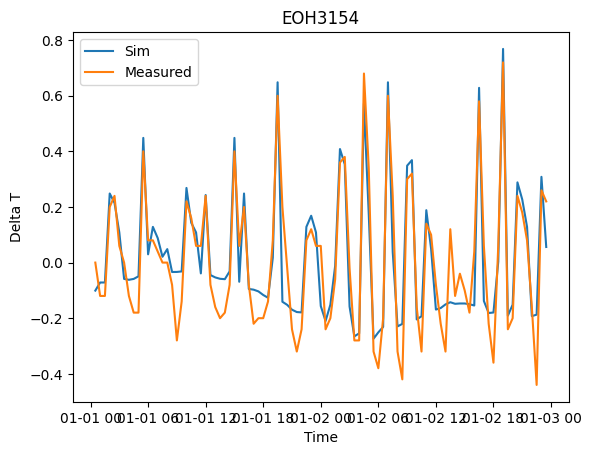

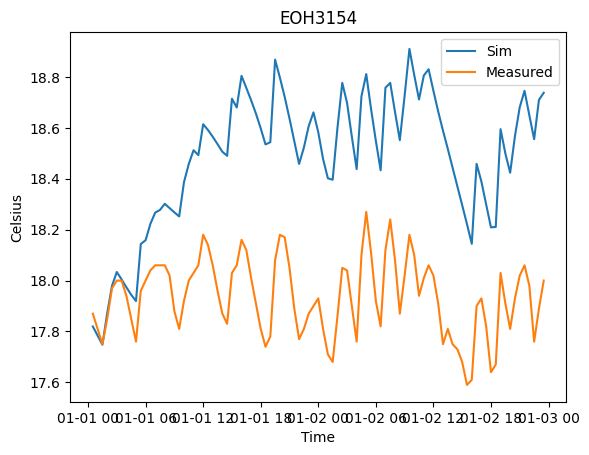

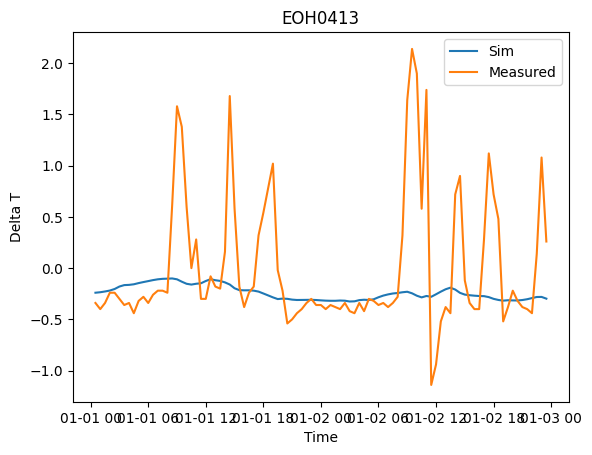

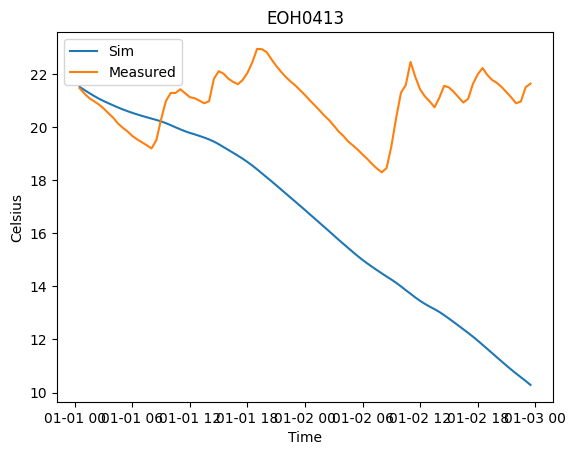

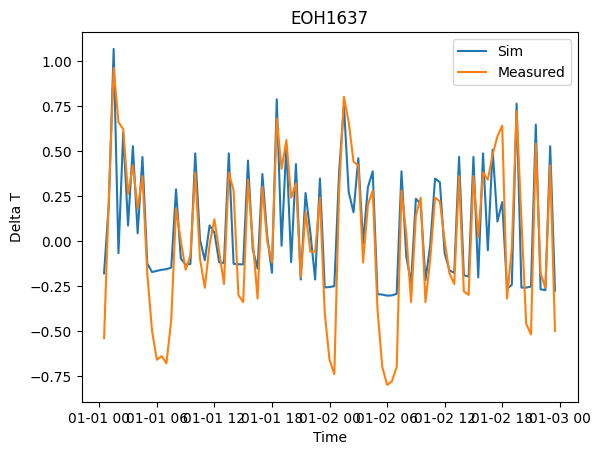

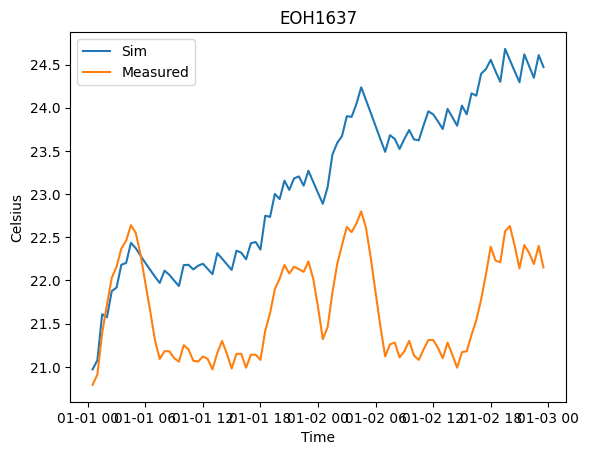

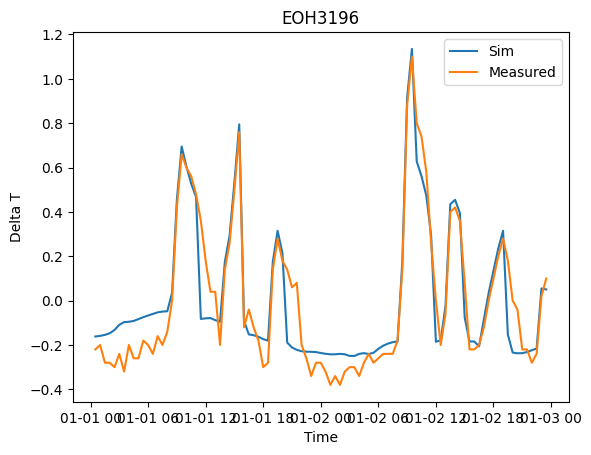

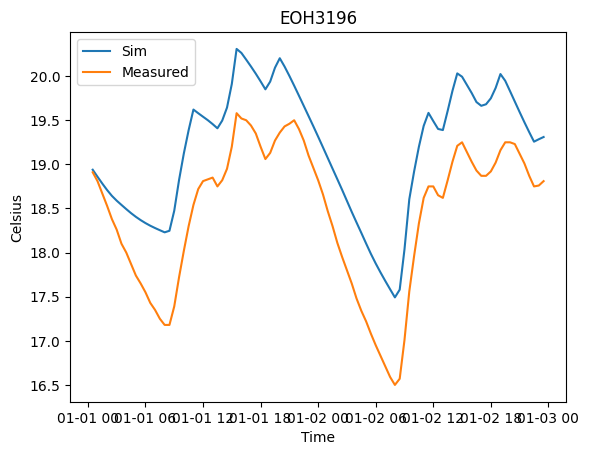

In [46]:
# -----Look at temperature tracking performance in the training --------------

for id_use in unique_ids:
    df_id = trained_params[id_use].copy()
    C = df_id.C
    R_a = df_id.R_a
    w_s= df_id.w_s
    w = df_id.w
    
    df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
    
    #re-adjust Heat Pump Diff and add temp differences
    df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
    df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
    df_single["Internal_Ambient_Temperature_Diff"] = \
        (df_single["External_Air_Temperature"] - 
         df_single["Internal_Air_Temperature"])
         
    
    
    # 1. Drop columns with almost all missing data (e.g., more than 90% missing)
    threshold = 0.90 * len(df_single)
    df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
    #print("Columns dropped due to high missing values:")
    #print(df_single.columns.difference(df_single_cleaned.columns).tolist())
    
    df_single = df_single_cleaned
    
    #print("\nColumns remaining after dropping highly missing columns:")
    #print(df_single.columns.tolist())
    
    # 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
    df_single = df_single.set_index('Timestamp')
    df_single = df_single.sort_index()
    
    # Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
    numeric_cols = df_single.select_dtypes(include=['number']).columns
    df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')
    
    df_single_interpolated = df_single.copy() 
    df_single_interpolated[numeric_cols] = df_single_numeric_interpolated
    
    # After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
    initial_rows = len(df_single_interpolated)
    df_single_processed = df_single_interpolated.dropna()
    rows_dropped_after_interpolation = initial_rows - len(df_single_processed)
    
    #print(f"\nNumber of rows dropped after handling NA values (missing for >
    # 2 hours): {rows_dropped_after_interpolation}")
    
    # -----EXTRACT SUMMER DATA -------# 
    df_heating_single = df_single_processed.copy()
    
    # Validate results
    t_start = pd.to_datetime("2022 01 01 00:00:00")
    t_end = pd.to_datetime("2022 01 02 23:59:00")
    df_q_id_use = df_q_id[(df_q_id.index>=t_start) & (df_q_id.index<=t_end)]
    df_heating_val = df_heating_single[df_heating_single.index>=t_start]
    df_heating_val = df_heating_val[df_heating_val.index<=t_end]
    
    
    
    T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
    delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
                 .reset_index(drop=True).to_numpy()) 
    delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
                 .reset_index(drop=True).to_numpy() / delta_t) 
    q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
            .reset_index(drop=True).to_numpy()) 
    q_opt = df_q_id_use[id_use].iloc[:-1].reset_index(drop=True).to_numpy()
    q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
               (drop=True).to_numpy()) 
    v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
              .to_numpy()) 
    
    
    delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_opt + w_s* q_solar_val + w
                     * np
                     .ones(len(T_a_val), )* delta_t) / C
    
    T_i_sim = np.zeros_like(T_i_val)
    T_i_prev = T_i_val[0]
    for i in range(len(delta_T_i_sim)):
        T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
        T_i_prev = T_i_sim[i]
    
    
    plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Delta T")
    plt.title(f"{id_use}")
    plt.show()
    
    plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
    plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
             .iloc[1:].reset_index
           (drop=True).to_numpy(), label = "Measured")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Celsius")
    plt.title(f"{id_use}")
    plt.show()